# Machine Learning: Week 9

## Probabilistic models, Bayes' classifier, Naive Bayes' classifier

This week we introduced probabilistic machine learning models in the lecture. In this workshop, we will look into **Naive Bayes' classifier** in more defail. Please download all files from blackboard before starting the notebook (the notebook itself + `categorical_jams.csv`, `fires_bejaia_ML.csv`).

We will go over the notebook together in the workshop. It contains several solved examples and some **exercises where you need to add some code**. If something does not run it might mean you need to alter or add a statement :) Also, **make sure you run all the code cells** (even the ones with examples) to ensure the rest of the notebook runs as intended.

We'll cover the following topics:
- [Categorical Naive Bayes' classifier](#Categorical-Naive-Bayes'-classifier)
    - [Step-by-step implementation](#Step-by-step-implementation)
        - [Exercise 1a](#Exercise-1a)
        - [Exercise 1b: Priors](#Exercise-1b:-Priors)
        - [Exercise 1c: Likelihoods](#Exercise-1c:-Likelihoods)
        - [Exercise 1d: Posteriors](#Exercise-1d:-Posteriors)
    - [Zero probability problem](#Zero-probability-problem)
        - [Exercise 2: Zero probability correction](#Exercise-2:-Zero-probability-correction)
    - [Making a class](#Making-a-class)
        - [Exercise 3: Implementing a class](#Exercise-3:-Implementing-a-class)
- [Gaussian Naive Bayes' classifier](#Gaussian-Naive-Bayes'-classifier)
    - [Exercise 4a: Training GaussianNB](#Exercise-4a:-Training-GaussianNB)
    - [Exercise 4b: Updating beliefs](#Exercise-4b:-Updating-beliefs)
    - [Exercise 4c: Removing correlated features](#Exercise-4c:-Removing-correlated-features)

In [6]:
import numpy as np
import pandas as pd

## Categorical Naive Bayes' classifier

Let us first look at a smiple toy dataset containing information about trafic jams on a certain road. 

In the dataset, three **types of featres** are recorded, with the following possible values:
- `weather`: {`Clear`, `Rainy`, `Snowy`}
- `timeOfWeek`: {`Workday`, `Weekend`}
- `timeOfDay`: {`Morning`, `Lunch`}

We will try to do this by manipulating [`pandas.DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) directly.

First, let's input the data and examine the dataset:

In [51]:
jams_df = pd.read_csv('categorical_jams.csv')

for column in jams_df.columns:
    jams_df[column] = jams_df[column].astype("category")
jams_df

,weather,timeOfWeek,timeOfDay,trafficJam
0,Clear,Workday,Morning,Yes
1,Rainy,Workday,Morning,Yes
2,Rainy,Workday,Morning,Yes
3,Clear,Workday,Morning,Yes
4,Rainy,Workday,Morning,Yes
5,Rainy,Weekend,Morning,No
6,Clear,Weekend,Morning,Yes
7,Rainy,Workday,Lunch,Yes
8,Snowy,Workday,Lunch,No
9,Clear,Workday,Lunch,Yes


### Step-by-step implementation

First, try to implement the Naive Bayes' classifier step-by-step. The formulas and appropriate pandas methods will be indicated in the exercises.

#### Exercise 1a

Store the name of the column containing our labels (= ground truth) in a variable called `label`, and the names of all the features in the variable called `features`. Assume the ground truth label is the last column in the dataset.

To retrieve the names of the columns in the [`pandas.DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html), you can use the [`pandas.DataFrame.columns`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.columns.html) attribute.

In [24]:
label = jams_df.columns[-1]
features = jams_df.columns[:-1]

print("Label = {}, features = {}".format(label, features))

Label = trafficJam, features = Index(['weather', 'timeOfWeek', 'timeOfDay'], dtype='object')


#### Exercise 1b: Priors

Calculate the **priors** for both of the classes (_i.e. both possible values of the `label` column_).

Remember, the prior probability of a class is _estimated from the dataset_ as the **number of samples of that class** in the dataset **divided by the total number of samples**:
$$
P(class = \texttt{No}) = \frac{N(class=\texttt{No})}{N},
$$
where $N$ is the total number of samples in the dataset, and $N(class==\texttt{No})$ is the number of samples of class `No`.

To implement this in with `pandas`, you can use [`pandas.DataFrame.value_counts()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.value_counts.html) method on the ground truth (`label`) column to obtain the total number of smaples from each class. To retrieve the total number of samples, you can look into [`pandas.DataFrame.shape`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shape.html) attribute, or use [`pandas.DataFrame.count()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.count.html) on the ground truth column.

In [52]:
# priors = 
priors = jams_df[label].value_counts(normalize=True)

priors

trafficJam
Yes    0.666667
No     0.333333
Name: proportion, dtype: float64

#### Exercise 1c: Likelihoods

Write a function `likelihood` which calculates the **likelihoods** for all possible values of a feature. As a reminder, the _likelihood_ of e.g. a certain weather condition _given_ the state of traffic (jam or not jam), can be _estimated from the data_ as:

$$
P(\texttt{Rainy}|class=\texttt{Yes}) = \frac{N(\texttt{Rainy}, class=\texttt{Yes})}{N(class=\texttt{Yes})},
$$
where $N(\texttt{Rainy}, class=\texttt{No})$ is the number of samples of class `Yes` where the weather was `Rainy`.

This needs to be calculated for **every possible value** of every feature. Fortunately, `pandas` provides the [`pandas.Dataframe.groupby()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html) method which allows performing such calculations for _all classes at once_. You will need to combine this with  [`pandas.DataFrame.value_counts()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.value_counts.html) and [`pandas.DataFrame.count()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.count.html), similarly to the [previous exercise](#Exercise-1b:-Priors).

Your function should return a `DataFrame` indexed by a [`pandas.MultiIndex`](https://pandas.pydata.org/docs/reference/api/pandas.MultiIndex.html#pandas.MultiIndex) -- i.e. the indexing column will contain both the ground truth `label`s, and the possible realisations of `feature`.

In [50]:
def likelihood(feature):

    return jams_df.groupby(label)[feature].value_counts(normalize=True)

print(likelihood('timeOfDay'))

trafficJam  timeOfDay
No          Lunch        0.571429
            Evening      0.285714
            Morning      0.142857
Yes         Morning      0.428571
            Evening      0.357143
            Lunch        0.214286
Name: proportion, dtype: float64


#### Exercise 1d: Posteriors

Write a (non-probabilistic) function `classify` which can be used to **classify a new sample** based on the weather, time of the week and time of the day.

To transform a _prior_ probability into a _posterior_ probability, Naive Bayes' assumes all features are _uncorrelated_ so the _likelihoods_ can be simply multiplied with the _prior_.

Multiplying the _prior_ with all the relevant _likelihoods_ gives you a _score_ for a class. To transform this score into the _posterior_ probability of that class, it needs to be normalised by the sum of _scores_ for each class.

For example, to transform the prior probability of there being a traffic jam, into a posterior probability, given the evidence $(x_1, x_2, x_3)$ = (`Rainy`, `Weekend`, `Evening`), we would calculate:

$$
\begin{align}
P(class = \texttt{Yes}|\texttt{Rainy}, \texttt{Weekend}, \texttt{Evening} ) &= \frac{P(class=\texttt{Yes})P(\texttt{Rainy}|class=\texttt{Yes})P(\texttt{Weekend}|class=\texttt{Yes})P(\texttt{Evening}|class=\texttt{Yes})}{\sum_i{P(class=i)P(\texttt{Rainy}|class=i)P(\texttt{Weekend}|class=i)P(\texttt{Evening}|class=i)}} \\
&= \frac{score(class=\texttt{Yes})}{\sum_i{score(class=i)}},
\end{align}
$$
with
$$
score(class=i|\texttt{Rainy}, \texttt{Weekend}, \texttt{Evening})=P(class=i)P(\texttt{Rainy}|class=i)P(\texttt{Weekend}|class=i)P(\texttt{Evening}|class=i).
$$


In general, if our sample is of form $x_1, x_2, x_3, ... x_n$, we can express the score as:

$$
\begin{align}
score(class=i|x_1, x_2, ... x_n) &=P(class=i)P(x_1|class=i)...P(x_n|class=i)  \\
& = P(class=i) \prod_{i=j..n}{P(x_j|class=i)},
\end{align}
$$
the product between the prior and the likelihoods of all the feature realisations from the sample.

To retrieve the likelihood $P(\texttt{Rainy}|class=i)$ (or for any other value of any other feature), you will need [`pandas.DataFrame.xs()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.xs.html) which allows you to select samples from the `DataFrame` by the _second_ key in the index (in our case, the value of the feature in the sample). To sum up different scores, you can use [`pandas.DataFrame.sum()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sum.html). To get an index of row with a maximum value, you can use [`pandas.DataFrame.idxmax()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.idxmax.html).

In [46]:
def classify(sample):

    # Copy over the priors to posteriors to work with
    posteriors = priors.copy()

    for feature_name, feature_realisation in zip(features, sample):
        posteriors *= likelihood(feature_name).xs(feature_realisation, level = 1) # 2nd level

    posteriors /= posteriors.sum()
    
    print(posteriors)
    return posteriors.idxmax()
    
print(classify(('Rainy', 'Weekend', 'Evening')))

trafficJam
Yes    0.97561
No     0.02439
Name: count, dtype: float64
Yes


### Zero probability problem

This problem can happen when we have a _very rare_ occurance of some feature value, which is _unrepresented_ (or, not sufficiently represented) in the dataset.

Let's examine the dataset together and try and see what would be the logical classification of (`Snowy`, `Workday`, `Morning`):

In [174]:
jams_df

,weather,timeOfWeek,timeOfDay,trafficJam
0,Clear,Workday,Morning,Yes
1,Rainy,Workday,Morning,Yes
2,Rainy,Workday,Morning,Yes
3,Clear,Workday,Morning,Yes
4,Rainy,Workday,Morning,Yes
5,Rainy,Weekend,Morning,No
6,Clear,Weekend,Morning,Yes
7,Rainy,Workday,Lunch,Yes
8,Snowy,Workday,Lunch,No
9,Clear,Workday,Lunch,Yes


You may say that it would make sense to predict `Yes`, there will be a traffic jam, because on every other `Workday` `Morning` in the dataset, there was a traffic jam.

However, `Snowy` weather is underrepresented in the dataset -- it never co-occurs with `trafficJam`=`Yes`. If we look at the likelihoods for `weather`, we can notice that the $P(\texttt{Snowy}|class=\texttt{Yes})$ is missing (we can take that as it having a value zero). Because of this, our classifier will **never predict a traffic jam in snowy weather!!**

In [47]:
print(likelihood('weather'))
print(classify(('Snowy', 'Weekend', 'Morning')))

trafficJam  weather
No          Snowy      0.190476
            Clear      0.095238
            Rainy      0.047619
Yes         Rainy      0.380952
            Clear      0.285714
Name: count, dtype: float64
trafficJam
Yes    NaN
No     1.0
Name: count, dtype: float64
No


#### Exercise 2: Zero probability correction

To cope with the above situation, we can add a very small value, e.g. $1$, to all the counts when calculating _likelihoods_. If we have $c$ classes, this transforms the formula for likelihood into:
$$
P(\texttt{Rainy} | class = i) = \frac{N(\texttt{Rainy},class=i)+1}{N(class=i)+c}.
$$

Make this change to the `likelihood` function implemented in [Exercise 1c](Exercise-1c:-Likelihoods), and re-run all the code cells up to this point. **How do the probabilities for a traffic jam in snowy weather look now?**

### Making a class

Now that you have implemented all the steps in the Naive Bayes' classifier for categorical features, try and puting them together in a class.

#### Exercise 3: Implementing a class

Implement a `myCategoricalNB` class, which operates on a [`pandas.DataFrame`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html). It should have the standard `__init__()`, `fit()` and `predict()` methods.

Also make a `predict_proba()` method which accepts the same arguments as `predict()` but returns a [`pandas.DataFrame`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) containing probabilities for both of the classes.

I suggest you also use a helper method `__likelihood()` with a similar function to the `likelihood` function defined in [Exercise 1c](Exercise-1c:-Likelihoods).

You can use the cell marked with **TESTING CELL** below to test how your classifier works.

In [68]:
class myCategoricalNB:
    def __init__(self):
        return
  
    def __likelihood(self, feature):
        return self.X.groupby(self.label)[feature].value_counts(normalize=True)
        
    def fit(self, X):

        self.X = X
        self.label = X.columns[-1]
        self.features = X.columns[:-1]
        self.priors = self.X[label].value_counts(normalize=True)
        
        return self

    def score(self, sample):
        scores = self.priors.copy()

        for feature_name, feature_realisation in zip(self.features, sample):
            posteriors *= self.__likelihood(feature_name).xs(feature_realisation, level = 1) # 2nd level
    
        return scores
    
    def predict(self, X):
        
        X = np.array(X)
        
        # This just ensures this works for single samples and
        # for list
        if len(X.shape) >= 2:
            return np.array([self.predict(x) for x in X])
        
        # add your implementation for predicting for a single sample here:
        score = self.__score(X)
        return score.idxmax(X)

    def predict_proba(self, X):
        
        X = np.array(X)
        
        # This just ensures this works for single samples and
        # for list
        if len(X.shape) >= 2:
            return pd.concat([self.predict_proba(x) for x in X], axis=1)
        
        # add your implementation for predicting for a single sample here:
        score = self.__score(X)
        score /= score.sum()

        return score

**TESTING CELL**

In [69]:
model = myCategoricalNB()
model.fit(jams_df)
model.predict(('Rainy', 'Weekend', 'Evening'))
model.predict_proba(('Snowy', 'Workday', 'Morning'))

samples = [('Rainy', 'Weekend', 'Evening'), 
           ('Snowy', 'Workday', 'Morning'),
           ('Clear', 'Weekend', 'Lunch'),
           ('Clear', 'Workday', 'Morning'),
           ('Rainy', 'Workday', 'Lunch'),
           ('Snowy', 'Workday', 'Lunch'),]

print(model.predict(samples))
model.predict_proba(samples)

AttributeError: 'myCategoricalNB' object has no attribute '_myCategoricalNB__score'

## Gaussian Naive Bayes' classifier

For this part of the workshop, we will work with a reduced dataset of [Algerian Forest Fires](https://archive.ics.uci.edu/ml/datasets/Algerian+Forest+Fires+Dataset++) [[1]](#References) (please download the file `fires_bejaia_ML.csv` from BlackBoard for this part). We will use the [`sklearn` implementation](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html) of Gaussian Naive Bayes' classifier. The dataset describes the weather conditions in Bejaia region of Algeria, and the presence or absence of Forest Fires, and contains the following features:

| Feature Name      | Value | Description |
| :---------------- | :----- | ----------- |
| `day`       | `int` | Day of the year. |
| `month` | `int` | Month of the year. |
| `year` | `int` | Calendar year. |
| `Temperature` | `int`: $^\circ C$ | Temperature on the day. |
| `RH` | `int`: % | Relative humidity. |
| `Ws` | `int`: km/h| Wind speed. |
| `Rain` | `float`: mm | Amount of rain on the day. |
| `FFMC` | `float` | Fine Fuel Moisture Code index. |
| `DMC` | `float` | Duff Moisture Code index. |
| `DC` | `float` |  Drought Code index. |
| `ISI` | `float` | Initial Spread Index. |
| `BUI` | `float` | Buildup Index. |
| `FWI` | `float` | Fire Weather Index. |
| `Classes` | `string` | Two classes: `fire` or `not fire`. |

First, let us load the dataset and inspect some samples to see what we are dealing with:

In [70]:
fires_df = pd.read_csv('fires_bejaia_ML.csv')
fires_df.head(6)

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
0,1,6,2012,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire
1,2,6,2012,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire
2,3,6,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire
3,4,6,2012,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire
4,5,6,2012,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,not fire
5,6,6,2012,31,67,14,0.0,82.6,5.8,22.2,3.1,7.0,2.5,fire


Let us also plot the relationship between some features.

For example, let us look at the relationship between relative humidity (`RH`) and the `DMC` index.

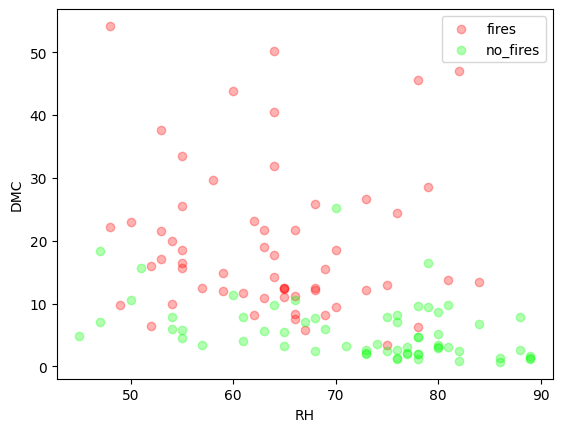

In [71]:
import matplotlib.pyplot as plt

fires = fires_df[fires_df.Classes == 'fire']
nofires = fires_df[fires_df.Classes == 'not fire']
plt.xlabel("RH")
plt.ylabel("DMC")
plt.scatter(fires.RH, fires.DMC, color = "red", label = "fires", alpha = 0.3)
plt.scatter(nofires.RH, nofires.DMC, color = "lime", label = "no_fires", alpha = 0.3)
plt.legend()
plt.show()

Examining the data, we can probaby safely _ignore the date_. We can also transform the class labels into one-hot encoded labels with [`pandas.get_dummies()`](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html).
To prepare our data for classification with the [Gaussian Naive Bayes' classifier](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html), let us then grab all the features _except_ the date, and class labels as zeros and ones.

(Since we have only two classes, we can interpret our one-hot label for `fire` as a unifying grount truth for the dataset, where `1` means there was a fire and `0` means there was no fire. The one-hot label for `not fire` is exactly the label for `fire` but negated.)

In [72]:
data_df = fires_df[fires_df.columns[3:-1]]
classes_df = pd.get_dummies(fires_df.Classes)

X = data_df.values
y = classes_df.fire.values

#classes_df

Let us also split the dataset into some training and testing samples. We will store our random selection in `train_idx` and `test_idx` so we can repeat exactly the same selection later. We will also use a fairly large size of the test set (60%) as we will be splitting it out further in the coming exercises.

In [73]:
from sklearn.model_selection import train_test_split

random_state = 3

train_idx, test_idx = train_test_split(np.arange(0, X.shape[0]), test_size = 0.6, random_state = random_state)

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(48, 10) (74, 10)
(48,) (74,)


#### Exercise 4a: Training GaussianNB

Initialise a classification model with the `sklearn` implementation of [`GaussianNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html).

Then, fit the model to the training data `X_train, y_train` using [`GaussianNB.fit()`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB.fit) method.

Finally, predict the outputs for the testing data using [`GaussianNB.predict()`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB.predict) method, and calculate the confusion matrix using [`metrics.confusion_matrix()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html). You can also try outputing all the probabilities with [`GaussianNB.predict_proba()`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB.predict_proba).

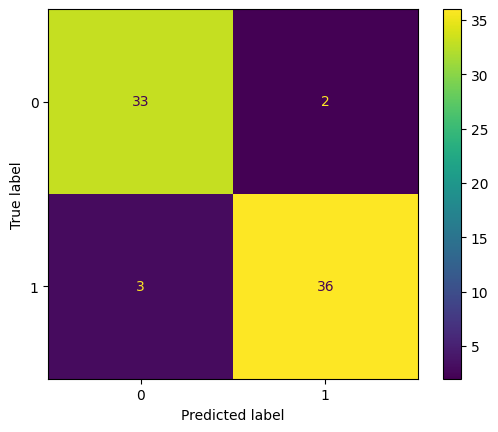

In [75]:
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

model_cont = GaussianNB()

# fit the model to the data:
model_cont.fit(X_train, y_train)
# predict the outputs:
y_predict = model_cont.predict(X_test)

confusion_matrix = metrics.confusion_matrix(y_predict, y_test)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
disp.plot()
plt.show()

#### Exercise 4b: Updating beliefs

With Naive Bayes' classifier, it is easy to _update beliefs_, if new data becomes available. The `sklearn` implementation supports that through [`GaussianNB.partial_fit()`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB.partial_fit). This can also be useful when you are handling so much data, you can not fit it in your memory all at once. In this case, you can still fit a Gaussian Navie Bayes' model to the data, part by part.

Perform the following steps:
- Split the `X_test` and `y_test` _further_ using [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) **in half** . Use the same `random_state` as above for epeatability.
- Initialise your model with a new instance of [`GaussianNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html) and fit the model to (`X_train`, `y_train`) using the [`GaussianNB.partial_fit()`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB.partial_fit). This model will also need a **list of all classes**. In this case, you can simply pass `[0, 1]` for the third argument, or more generally, you can use [`numpy.unique()`](https://numpy.org/doc/stable/reference/generated/numpy.unique.html) on your training labels (`y_train`) if you are certain all the labels are contained in the training set.
- Calculate the confusion matrix `cm` for this case, to convince yourself it is the same one as in [Exercise 4a](Exercise-4a:-Training-GaussianNB) when we used [`GaussianNB.fit()`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB.fit)
- Also evaluate this model on the reduced testing set `X_test_new` and produce a confusion matrix `cm_small` by comparing these outputs to `y_test_new`.
- Using [`GaussianNB.partial_fit()`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB.partial_fit) fit the model to further data (`X_train_new`, `y_train_new`).
- Finally, evaluate the model on the the reduced testing set `X_test_new` again and produce an updated confusion matrix `cm_after` by comparing these outputs to `y_test_new`. Compare the performance of the model before and after training on additional data

_Note: another (cheaty) reason you are asked to use the same `random_state=3` is because this random state actually results in an improvement to the classifier. As we are using quite a small dataset, not all random seeds do -- but adding more data generally helps the classifier in the wild._

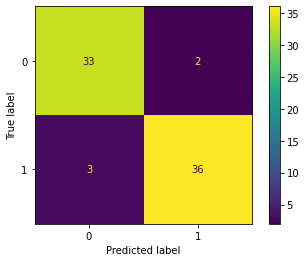

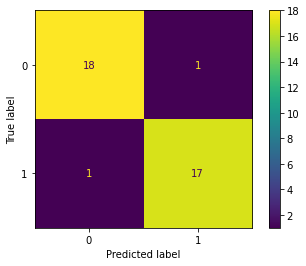

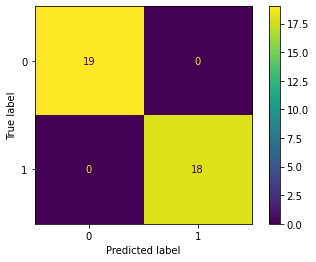

In [186]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
        X_test, y_test, test_size = 0.5, random_state = random_state)

model_cont = # ...
# fit the model to the (old) training data using partial_fit:
# ...
cm = # ..

disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

cm_small = # ...
disp_small = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_small)
disp_small.plot()

# fit the model to more training data using partial_fit:
# ...

cm_after = # ...
disp_after = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_after)
disp_after.plot()

plt.show()

#### Exercise 4c: Removing correlated features

The Naive Bayes' classifier assumes all features are _uncorrelated_. However, this is often not true in the real world. While it still often works well enough in practice (as seen on the example above), having highly correlated features in the dataset does not contribute much to its performance.

In this exercise, you should first examine the correlation matrix between all the different features obtained with [`pandas.DataFrame.corr()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) (just run the next cell for now and study it! and read on).

In [187]:
fires_df.head()
fires_df[fires_df.columns[3:-1]].corr()

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI
Temperature,1.000000,-0.660151,-0.228035,-0.486947,0.748423,0.541489,0.532838,0.663871,0.542210,0.608367
RH,-0.660151,1.000000,0.245774,0.329163,-0.653153,-0.347080,-0.314271,-0.586410,-0.338233,-0.476067
Ws,-0.228035,0.245774,1.000000,0.349321,-0.211069,0.039394,0.099231,-0.039266,0.062212,0.029637
Rain,-0.486947,0.329163,0.349321,1.000000,-0.573476,-0.265371,-0.283652,-0.366425,-0.271951,-0.292914
FFMC,0.748423,-0.653153,-0.211069,-0.573476,1.000000,0.608512,0.575221,0.790086,0.600707,0.675553
DMC,0.541489,-0.347080,0.039394,-0.265371,0.608512,1.000000,0.962193,0.750098,0.995551,0.901759
DC,0.532838,-0.314271,0.099231,-0.283652,0.575221,0.962193,1.000000,0.717591,0.982554,0.869911
ISI,0.663871,-0.586410,-0.039266,-0.366425,0.790086,0.750098,0.717591,1.000000,0.746761,0.944062
BUI,0.542210,-0.338233,0.062212,-0.271951,0.600707,0.995551,0.982554,0.746761,1.000000,0.900417
FWI,0.608367,-0.476067,0.029637,-0.292914,0.675553,0.901759,0.869911,0.944062,0.900417,1.000000


Correlation can be:
- 1: this means that you can calculate the value of one feature _exactly_ from the value of the other feature
- close to 1: this means that the features are _highly correlated_ -- you can _predict_ one from the other with a _high accuracy_
- close to -1: this means that the features are _highly negatively correlated_ -- you can still _predict_ one from the other with a _high accuracy_, just that as the first feature increases, the second decreases
- close to 0: there is little to no relationship between the two features.

Examining the above correlation table, select only $5$ features for the reduced training set `X_reduced`. (It will still contain information about all the days from the dataset, but will be reduced in the number of features used). You can simply do this by passing a list of features into the dataframe, e.g: `fires_df[['Ws, 'ISI']]` (and retrieving the data through the `values` attribute).

Initialise a new instance of [`GaussianNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html) and fit the model to (`X_train_train`, `y_train`) using the [`GaussianNB.fit()`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB.fit) method. Then, predict the outputs for `X_reduced_test` with [`GaussianNB.predict()`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB.predict) method, and calculate the confusion matrix using [`metrics.confusion_matrix()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html), by comparing those outputs with `y_test`.

Compare the confusion matrix obtained with a reduced set of features with the one from [Exercise 4a](#Exercise-4a:-Training-GaussianNB). **Did the classifier performance change much?**

Try experimenting with different feature combinations in the classifier, and see how little features you can use while still obtaining good classification results.

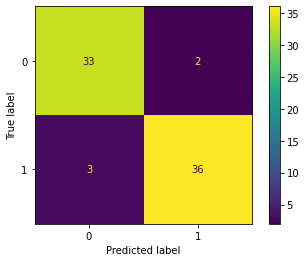

In [189]:
X_reduced = fires_df.values # replace this line to select only 5 features from the dataset
X_reduced_train, X_reduced_test = X_reduced[train_idx], X_reduced[test_idx]

model_reduced = # ...

# fit the model to the data:

# predict the results and calculate confusion matrix:
cm_reduced = # ...

disp_after = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_reduced)
disp_after.plot()
plt.show()

## References

[1] _Abid, Faroudja, and Nouma Izeboudjen. "Predicting forest fire in algeria using data mining techniques: Case study of the decision tree algorithm." International Conference on Advanced Intelligent Systems for Sustainable Development. Springer, Cham, 2020._